In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.2.0
Eager execution: True


In [3]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: C:\Users\LONAA32\.keras\datasets\iris_training.csv


In [4]:
data = pd.read_csv(train_dataset_fp)
data.head()

,120,4,setosa,versicolor,virginica
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [5]:
len(data)

120

In [7]:
# column order in CSV file
COLUMN_NAMES = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
FEATURE_NAMES = COLUMN_NAMES[:-1]
LABEL_NAME = COLUMN_NAMES[-1]

print("Features: {}".format(FEATURE_NAMES))
print("Label: {}".format(LABEL_NAME))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [8]:
LABEL_NAME

'species'

In [9]:
def create_dataset(file_path, batch_size=1, mode='eval'):

    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size,
        column_names=COLUMN_NAMES,
        label_name=LABEL_NAME)

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=100).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [53]:
BATCH_SIZE = 32

trainids = create_dataset(train_dataset_fp, batch_size=BATCH_SIZE, mode='train')

In [25]:
features, labels = next(iter(trainids))

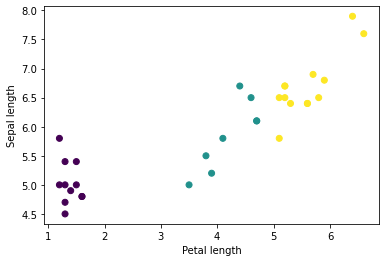

In [26]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [27]:
# Create input layer of feature columns
feature_columns = {header: tf.feature_column.numeric_column(header) for header in FEATURE_NAMES}

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(feature_columns=feature_columns.values()),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [29]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.03064494, 0.2332905 , 0.7360646 ],
       [0.12677322, 0.2883351 , 0.5848917 ],
       [0.11953376, 0.28181782, 0.5986484 ],
       [0.12238251, 0.27817017, 0.59944737],
       [0.04213228, 0.25237015, 0.70549756]], dtype=float32)>

In [30]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("Labels: {}".format(labels))

Prediction: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Labels: [2 0 0 0 1 1 1 2 2 0 2 2 2 0 2 2 2 0 2 1 0 2 0 0 1 0 1 2 1 2 0 1]


In [39]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the keras model
model.compile(optimizer="adam",
             loss=loss_object,
             metrics=["mse", "accuracy"])

In [50]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 120 * 5 # training dataset will repeat, wrap around
NUM_EVALS = 100  # how many times to evaluate
NUM_EVAL_EXAMPLES = 20  # enough to get a reasonable sample

trainds = create_dataset(
    file_path=train_dataset_fp,
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    file_path=train_dataset_fp,
    batch_size=20,
    mode='eval').take(NUM_EVAL_EXAMPLES//20)

In [48]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)
steps_per_epoch

9

In [51]:
%time 
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds,
                    steps_per_epoch=300,
                    epochs=NUM_EVALS,
                    validation_data=evalds)

Wall time: 0 ns
Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 0.5610 - mse: 1.3660 - accuracy: 0.9912 - val_loss: 0.5520 - val_mse: 1.5494 - val_accuracy: 1.0000
Epoch 2/100
300/300 [==============================] - 0s 974us/step - loss: 0.5598 - mse: 1.3655 - accuracy: 0.9922 - val_loss: 0.6020 - val_mse: 1.5995 - val_accuracy: 0.9500
Epoch 3/100
300/300 [==============================] - 0s 936us/step - loss: 0.5604 - mse: 1.3733 - accuracy: 0.9916 - val_loss: 0.5526 - val_mse: 1.2488 - val_accuracy: 1.0000
Epoch 4/100
300/300 [==============================] - 0s 922us/step - loss: 0.5610 - mse: 1.3599 - accuracy: 0.9909 - val_loss: 0.5519 - val_mse: 1.3662 - val_accuracy: 1.0000
Epoch 5/100
300/300 [==============================] - 0s 910us/step - loss: 0.5593 - mse: 1.3644 - accuracy: 0.9926 - val_loss: 0.5523 - val_mse: 1.1492 - val_accuracy: 1.0000
Epoch 6/100
300/300 [==============================] - 0s 909us/step - loss: 0.5607 - mse: 1.3678 - a

In [52]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [64]:
BATCH_SIZE = 32

trainids = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size = BATCH_SIZE,
    column_names=COLUMN_NAMES,
    label_name=LABEL_NAME,
    num_epochs=1)

# train_dataset = trainids.map(pack_features_vector)

In [65]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.6 3.  4.4 1.4]
 [4.4 3.2 1.3 0.2]
 [5.4 3.9 1.3 0.4]
 [7.9 3.8 6.4 2. ]
 [5.5 2.4 3.8 1.1]], shape=(5, 4), dtype=float32)


In [67]:
%time 

history = model.fit(trainids,
                    epochs=20)

Wall time: 0 ns
Epoch 1/20
4/4 [==============================] - 0s 10ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 2/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 3/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 4/20
4/4 [==============================] - 0s 904us/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 5/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 6/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 7/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 8/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy: 0.9833
Epoch 9/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5681 - mse: 1.3667 - accuracy

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  50        
_________________________________________________________________
dense_7 (Dense)              multiple                  110       
_________________________________________________________________
dense_8 (Dense)              multiple                  33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [44]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [45]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

KeyError: "None of [Index(['rmse', 'val_rmse'], dtype='object')] are in the [columns]"

<AxesSubplot:>

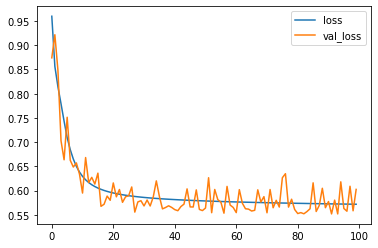

In [46]:
RMSE_COLS = ['loss', "val_loss"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [47]:
data.head()

,120,4,setosa,versicolor,virginica
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [48]:
import numpy as np

In [49]:
np.round(model.predict(x={"sepal_length": tf.convert_to_tensor([5]),
                 "sepal_width": tf.convert_to_tensor([3]),
                 "petal_length": tf.convert_to_tensor([1.6]),
                 "petal_width": tf.convert_to_tensor([0.6])},
              steps=1))

array([[1., 0., 0.]], dtype=float32)

## Evaluate the model's effectiveness


In [50]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

In [51]:
test_dataset = create_dataset(train_dataset_fp, batch_size=BATCH_SIZE, mode='eval')

In [52]:
for features, label in test_dataset.take(1):
    print(features, label)
    break

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.3, 6.1, 5.3, 5.1, 4.9, 4.7, 6.1, 5. , 5.5, 6. , 5.2, 5.2, 6.4,
       5.1, 5.7, 5.6, 5.7, 6.4, 5.4, 5. , 4.9, 6.5, 6. , 6. , 5.4, 5.6,
       6.8, 5. , 5.4, 6.7, 5.1, 5. ], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.3, 2.8, 3.7, 3.8, 2.4, 3.2, 2.9, 2.3, 2.4, 2.2, 2.7, 3.4, 2.7,
       3.8, 3.8, 2.9, 2.8, 2.8, 3. , 3.5, 2.5, 3.2, 3. , 2.7, 3.7, 2.7,
       3.2, 3.2, 3.4, 3.1, 3.7, 2. ], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6. , 4.7, 1.5, 1.5, 3.3, 1.6, 4.7, 3.3, 3.7, 5. , 3.9, 1.4, 5.3,
       1.6, 1.7, 3.6, 4.5, 5.6, 4.5, 1.6, 4.5, 5.1, 4.8, 5.1, 1.5, 4.2,
       5.9, 1.2, 1.5, 5.6, 1.5, 3.5], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([2.5, 1.2, 0.2, 0.3, 1. , 0.2, 1.4, 1. , 1. , 1.5, 1.4, 0.2, 1.9,
       0.2, 0.3, 1.3, 1.3, 2.2, 1.5, 0.6, 1.7, 2. , 1.8, 1.6,

In [53]:
model.predict(test_dataset, steps=1)

array([[7.4254902e-05, 9.9992394e-01, 1.8123452e-06],
       [4.9467626e-09, 8.1731814e-05, 9.9991822e-01],
       [4.6959534e-09, 3.5739282e-05, 9.9996424e-01],
       [1.4191461e-09, 1.0940657e-05, 9.9998903e-01],
       [2.1305029e-06, 2.0762891e-02, 9.7923499e-01],
       [9.9963856e-01, 3.6141084e-04, 3.0897693e-19],
       [3.9265839e-09, 8.0860827e-06, 9.9999189e-01],
       [1.1296302e-08, 1.0726749e-04, 9.9989271e-01],
       [9.9875152e-01, 1.2485125e-03, 2.7598261e-18],
       [9.9997282e-01, 2.7238191e-05, 8.6142254e-23],
       [6.4029743e-10, 7.4865366e-06, 9.9999249e-01],
       [2.4980212e-05, 1.5052092e-01, 8.4945410e-01],
       [1.0333358e-04, 9.9937385e-01, 5.2288710e-04],
       [9.9991214e-01, 8.7816719e-05, 7.5942984e-21],
       [9.9961603e-01, 3.8397330e-04, 5.9129259e-19],
       [1.8480746e-04, 9.9901450e-01, 8.0060679e-04],
       [1.4708106e-08, 1.0180258e-04, 9.9989820e-01],
       [1.3564518e-09, 7.0440424e-06, 9.9999297e-01],
       [1.1323080e-04, 9.998

In [54]:
y = []
for features, labels in test_dataset.take(1):
    y = labels.numpy()

In [55]:
y

array([1, 2, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 0, 2, 1, 0,
       0, 2, 2, 2, 0, 2, 0, 1, 2, 0])

In [56]:
x = []
for prediction in model.predict(test_dataset, steps=1):
    x.append(tf.argmax(prediction).numpy())

In [57]:
x

[2,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 2]

In [58]:
tf.stack([y,x],axis=1)

<tf.Tensor: shape=(32, 2), dtype=int32, numpy=
array([[1, 2],
       [2, 2],
       [1, 2],
       [1, 1],
       [0, 2],
       [2, 0],
       [0, 2],
       [2, 0],
       [1, 0],
       [0, 2],
       [0, 2],
       [0, 0],
       [1, 2],
       [2, 1],
       [2, 0],
       [1, 2],
       [0, 2],
       [1, 1],
       [0, 1],
       [2, 1],
       [1, 1],
       [0, 0],
       [0, 1],
       [2, 0],
       [2, 0],
       [2, 2],
       [0, 2],
       [2, 1],
       [0, 0],
       [1, 2],
       [2, 2],
       [0, 2]])>